# Factor Analysis

## Preprocess

In [104]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import os
import warnings

warnings.filterwarnings("ignore")

In [105]:
# read file
adl_path = "../data/data_adl.pkl"
df = pd.read_pickle(adl_path)

In [106]:
# bartlett and kmo test
kmo = calculate_kmo(df)
bartlett = calculate_bartlett_sphericity(df)
print("Factor Analysis Suitability Test")
print(f"KMO statistic: {bartlett[0]:.4f}")
print("KMO: {:.4f}\nBartlett: {:.4f}".format(kmo[1], bartlett[1]))
if kmo[1] > 0.9 and bartlett[1] < 0.05:
    print("FA suitability test passes!")

Factor Analysis Suitability Test
KMO statistic: 276143.2095
KMO: 0.9428
Bartlett: 0.0000
FA suitability test passes!


## Function Definition

In [107]:
def factor_analysis(df, factor=1, rot=None, m="principal"):
    fa = FactorAnalyzer(n_factors=factor, method=m, rotation=rot)
    fa.fit(df)
    return fa

In [108]:
def scree_plot(df, original=True, method="principal", plot=True):
    fa = factor_analysis(df, df.shape[1], rot=None, m=method)
    ev = np.array(fa.get_eigenvalues()).T
    df_ev = pd.DataFrame(ev, columns=["Original Eigenvalues", "Common Factor Eigenvalues"], index=df.columns)
    if plot:
        ev_dat = df_ev.iloc[:, 0].copy() if original else df_ev.iloc[:, 1].copy()
        plt.scatter(range(1, df.shape[1]+1), ev_dat)
        plt.plot(range(1, df.shape[1]+1), ev_dat)
        plt.title('Scree Plot')
        plt.xlabel('Factors')
        plt.ylabel('Eigenvalue')
        plt.grid()
        plt.show()
    return df_ev

In [109]:
def variance_explained_plot(df, var_type=0, method="principal", plot=True):
    fa = factor_analysis(df, df.shape[1], rot=None, m=method)
    var = np.array(fa.get_factor_variance()).T
    df_var = pd.DataFrame(var, columns=["Variance", "Proportional Variance", "Cumulative Variance"], index=df.columns)
    var_list = [df_var[i] for i in df_var.columns]
    if plot:
        var_dat = var_list[var_type]
        plt.scatter(range(1, df.shape[1]+1), var_dat)
        plt.plot(range(1, df.shape[1]+1), var_dat)
        plt.title(f'{var_dat.name} Plot')
        plt.xlabel('Factors')
        plt.ylim((0, 1.1))
        plt.grid()
        plt.show()
    var, pvar, cvar = var_list
    return var, pvar, cvar

In [110]:
def fa_result(df, fa):
    cols = [("Factor" + str(i+1)) for i in range(fa.loadings_.shape[1])]
    loadings = pd.DataFrame(fa.loadings_, columns=cols, index=df.columns)
    communalities = pd.DataFrame(fa.get_communalities(), columns=["Communalities"], index=df.columns)
    uniquenesses = pd.DataFrame(fa.get_uniquenesses(), columns=["Uniquenesses"], index=df.columns)
    result = pd.concat([loadings, communalities, uniquenesses], axis=1)
    score = pd.DataFrame(fa.transform(df))
    return result, score

In [111]:
def loadings_plot(df, title="", xlabel="Factor1", ylabel="Factor2", ax=None):
    col_num = len(df.columns)
    if col_num == 2:
        if ax is None:
            plt.scatter(df[df.columns[0]], df[df.columns[1]])
            for i in range(df.shape[0]):
                plt.text(x=df[df.columns[0]][i], y=df[df.columns[1]][i], s=df.index[i])
            if title:
                plt.title(title)
            else:
                plt.title("Loadings Plot")
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.axvline(x=0, color='blue')
            plt.axhline(y=0, color='blue')
            plt.show()
        else:
            ax.scatter(df[df.columns[0]], df[df.columns[1]])
            for i in range(df.shape[0]):
                ax.text(x=df[df.columns[0]][i], y=df[df.columns[1]][i], s=df.index[i])
            if title:
                ax.set_title(title)
            else:
                ax.set_title("Loadings Plot")
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.axvline(x=0, color='blue')
            ax.axhline(y=0, color='blue')
            # ax.show()

## PCFA

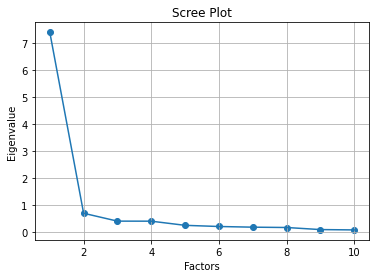

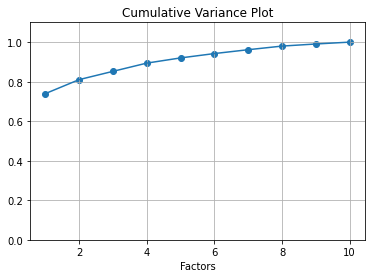

In [112]:
pcfa_ev = scree_plot(df)
pcfa_var, pcfa_pvar, pcfa_cvar = variance_explained_plot(df, var_type=2)

In [113]:
pc_result, pc_score, pc_label = [], [], []
lbl = "pcfa"
for i in range(1, 4):
    for rotation in [None, "varimax"]:
        tmp_lbl = lbl + str(i)
        pcfa = fa_result(df, factor_analysis(df, factor=i, rot=rotation))
        pc_result.append(pcfa[0])
        pc_score.append(pcfa[1])
        if rotation:
            tmp_lbl = tmp_lbl + "_" + rotation
        pc_label.append(tmp_lbl)

In [114]:
for i in range(len(pc_score)):
    df_score = pc_score[i].to_numpy()
    with open(f"../npy/data_adl_{pc_label[i]}.npy", 'wb') as f:
        np.save(f, df_score)

## MLFA

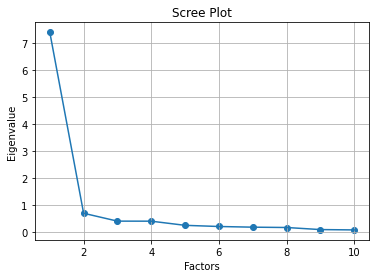

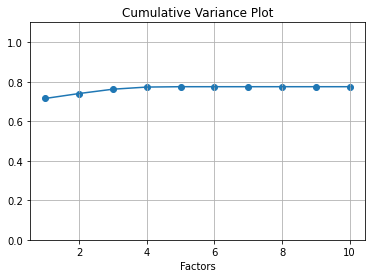

In [115]:
mlfa_ev = scree_plot(df, method="ml")
mlfa_var, mlfa_pvar, mlfa_cvar = variance_explained_plot(df, var_type=2, method="ml")

In [116]:
ml_result, ml_score, ml_label = [], [], []
lbl = "mlfa"
for i in range(1, 4):
    for rotation in [None, "varimax", "oblimin"]:
        tmp_lbl = lbl + str(i)
        mlfa = fa_result(df, factor_analysis(df, factor=i, rot=rotation, m="ml"))
        ml_result.append(mlfa[0])
        ml_score.append(mlfa[1])
        if rotation:
            tmp_lbl = tmp_lbl + "_" + rotation
        ml_label.append(tmp_lbl)

In [117]:
for i in range(len(ml_score)):
    df_score = ml_score[i].to_numpy()
    with open(f"../npy/data_adl_{ml_label[i]}.npy", 'wb') as f:
        np.save(f, df_score)

## Analysis

### Overview

In [118]:
print(pc_label)
print(ml_label)

['pcfa1', 'pcfa1_varimax', 'pcfa2', 'pcfa2_varimax', 'pcfa3', 'pcfa3_varimax']
['mlfa1', 'mlfa1_varimax', 'mlfa1_oblimin', 'mlfa2', 'mlfa2_varimax', 'mlfa2_oblimin', 'mlfa3', 'mlfa3_varimax', 'mlfa3_oblimin']


In [119]:
pc_score[3]

,0,1
0,-0.943011,0.208695
1,3.573965,0.901020
2,-0.079943,0.255419
3,-0.648182,0.127471
4,-0.434582,-0.840839
...,...,...
25389,-0.585841,-0.382892
25390,-0.693681,-1.159858
25391,2.020751,-0.915735
25392,0.899448,0.110161


In [120]:
pc_result[3]

,Factor1,Factor2,Communalities,Uniquenesses
H2a,0.855200,0.228555,0.783605,0.216395
H2b,0.838628,0.369868,0.840099,0.159901
H2c,0.729628,0.519625,0.802367,0.197633
H2d,0.230227,0.942431,0.941181,0.058819
H2e,0.855371,0.312740,0.829466,0.170534
H2f,0.835082,0.377862,0.840142,0.159858
H2g,0.833563,0.135576,0.713209,0.286791
H2h,0.805206,0.404414,0.811908,0.188092
H2i,0.857963,0.240998,0.794180,0.205820
H2j,0.737994,0.449890,0.747036,0.252964


### Factor loadings

#### PCFA

In [121]:
pc_loadings = None
for i in range(len(pc_result)):
    label = pc_label[i]
    if "1" in label:
        sub = pc_result[i]["Factor1"]
    elif "2" in label:
        sub = pc_result[i][["Factor1", "Factor2"]]
    elif "3" in label:
        sub = pc_result[i][["Factor1", "Factor2", "Factor3"]]
    if pc_loadings is not None:
        pc_loadings = pd.concat([pc_loadings, sub], axis=1)
    else:
        pc_loadings = sub

#### MLFA

In [122]:
ml_loadings = None
for i in range(len(ml_result)):
    label = ml_label[i]
    if "1" in label:
        sub = ml_result[i]["Factor1"]
    elif "2" in label:
        sub = ml_result[i][["Factor1", "Factor2"]]
    elif "3" in label:
        sub = ml_result[i][["Factor1", "Factor2", "Factor3"]]
    if ml_loadings is not None:
        ml_loadings = pd.concat([ml_loadings, sub], axis=1)
    else:
        ml_loadings = sub

In [123]:
if not os.path.exists("../table/"):
    os.mkdir("./table/")

writer = pd.ExcelWriter('../table/fa_loadings.xlsx', engine='xlsxwriter')
np.round(pc_loadings, 4).to_excel(writer, sheet_name='pcfa')
np.round(ml_loadings, 4).to_excel(writer, sheet_name='mlfa')

writer.close()

### Communalities summary

#### PCFA

In [124]:
communalities_pc = None
for i in range(len(pc_result)):
    com = pc_result[i].rename(columns={"Communalities": f"{pc_label[i]}"})[f"{pc_label[i]}"]
    if communalities_pc is None:
        communalities_pc = com
    else:
        communalities_pc = pd.concat([communalities_pc, com], axis=1)

In [125]:
communalities_pc

,pcfa1,pcfa1_varimax,pcfa2,pcfa2_varimax,pcfa3,pcfa3_varimax
H2a,0.752816,0.752816,0.783605,0.783605,0.801957,0.801957
H2b,0.838375,0.838375,0.840099,0.840099,0.841937,0.841937
H2c,0.782463,0.782463,0.802367,0.802367,0.805000,0.805000
H2d,0.390875,0.390875,0.941181,0.941181,0.975693,0.975693
H2e,0.819439,0.819439,0.829466,0.829466,0.851546,0.851546
H2f,0.839067,0.839067,0.840142,0.840142,0.886647,0.886647
H2g,0.651141,0.651141,0.713209,0.713209,0.880630,0.880630
H2h,0.811890,0.811890,0.811908,0.811908,0.841416,0.841416
H2i,0.766773,0.766773,0.794180,0.794180,0.804633,0.804633
H2j,0.741426,0.741426,0.747036,0.747036,0.832142,0.832142


#### MLFA

In [126]:
communalities_ml = None
for i in range(len(ml_result)):
    com = ml_result[i].rename(columns={"Communalities": f"{ml_label[i]}"})[f"{ml_label[i]}"]
    if communalities_ml is None:
        communalities_ml = com
    else:
        communalities_ml = pd.concat([communalities_ml, com], axis=1)

In [127]:
communalities_ml

,mlfa1,mlfa1_varimax,mlfa1_oblimin,mlfa2,mlfa2_varimax,mlfa2_oblimin,mlfa3,mlfa3_varimax,mlfa3_oblimin
H2a,0.731707,0.731707,0.731707,0.773935,0.773935,0.671134,0.857619,0.857619,0.892564
H2b,0.824519,0.824519,0.824519,0.972690,0.972690,0.801941,0.912771,0.912771,0.820693
H2c,0.749585,0.749585,0.749585,0.769241,0.769241,0.679737,0.849637,0.849637,0.555836
H2d,0.335936,0.335936,0.335936,0.327002,0.327002,0.323960,0.456392,0.456392,0.275765
H2e,0.812833,0.812833,0.812833,0.863658,0.863658,0.946109,0.888362,0.888362,1.022184
H2f,0.838204,0.838204,0.838204,0.877725,0.877725,0.941919,0.884413,0.884413,0.888306
H2g,0.602348,0.602348,0.602348,0.592360,0.592360,0.599689,0.614235,0.614235,0.369363
H2h,0.795923,0.795923,0.795923,0.784901,0.784901,0.781569,0.796278,0.796278,0.433058
H2i,0.731250,0.731250,0.731250,0.727644,0.727644,0.758203,0.725614,0.725614,0.476939
H2j,0.709551,0.709551,0.709551,0.723337,0.723337,0.777073,0.740798,0.740798,0.660727


In [128]:
writer = pd.ExcelWriter('../table/fa_communalities.xlsx', engine='xlsxwriter')

np.round(communalities_pc, 4).to_excel(writer, sheet_name='pcfa')
np.round(communalities_ml, 4).to_excel(writer, sheet_name='mlfa')

writer.close()

In [129]:
if not os.path.exists("../table/"):
    os.mkdir("./table/")

writer = pd.ExcelWriter('../table/fa_communalities_reduced.xlsx', engine='xlsxwriter')

np.round(communalities_pc, 4)[["pcfa1", "pcfa2", "pcfa3"]].to_excel(writer, sheet_name='pcfa')
np.round(communalities_ml, 4)[["mlfa1", "mlfa2", "mlfa3", "mlfa1_oblimin", "mlfa2_oblimin", "mlfa3_oblimin"]].to_excel(writer, sheet_name='mlfa')

writer.close()

### PCFA: 2 factors

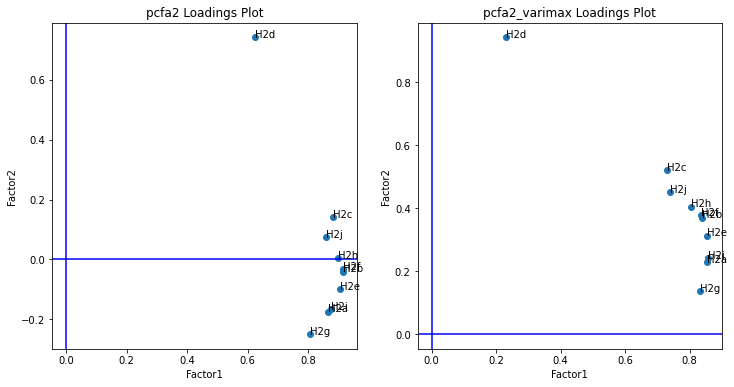

In [130]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2, figsize=(12, 6)
)
loadings_plot(pc_result[2][["Factor1", "Factor2"]], f"{pc_label[2]} Loadings Plot", ax=ax1)
loadings_plot(pc_result[3][["Factor1", "Factor2"]], f"{pc_label[3]} Loadings Plot", ax=ax2)
fig.savefig("../fig/fa_pcfa2_loadings.png")

### PCFA: 3 factors

#### PCFA3

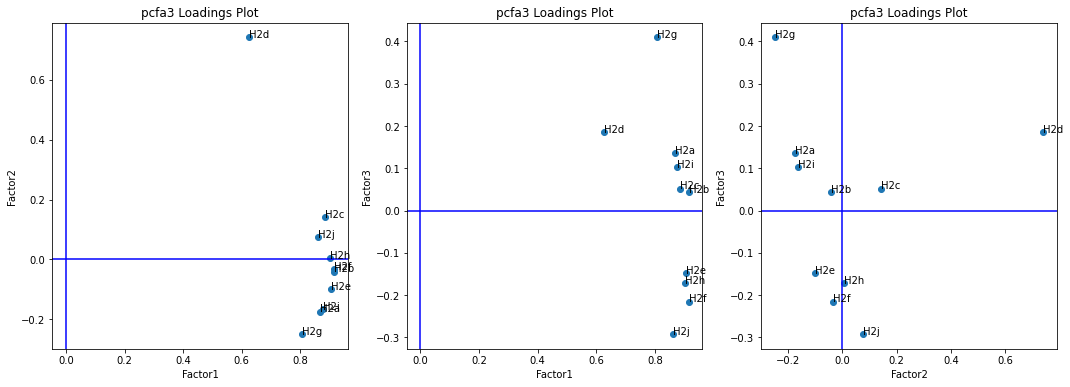

In [131]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(18, 6)
)
loadings_plot(pc_result[4][["Factor1", "Factor2"]], f"{pc_label[4]} Loadings Plot", ax=ax1)
loadings_plot(pc_result[4][["Factor1", "Factor3"]], f"{pc_label[4]} Loadings Plot", ylabel="Factor3", ax=ax2)
loadings_plot(pc_result[4][["Factor2", "Factor3"]], f"{pc_label[4]} Loadings Plot", xlabel="Factor2", ylabel="Factor3", ax=ax3)
fig.savefig("../fig/fa_pcfa3_loadings.png")

#### PCFA3_varimax

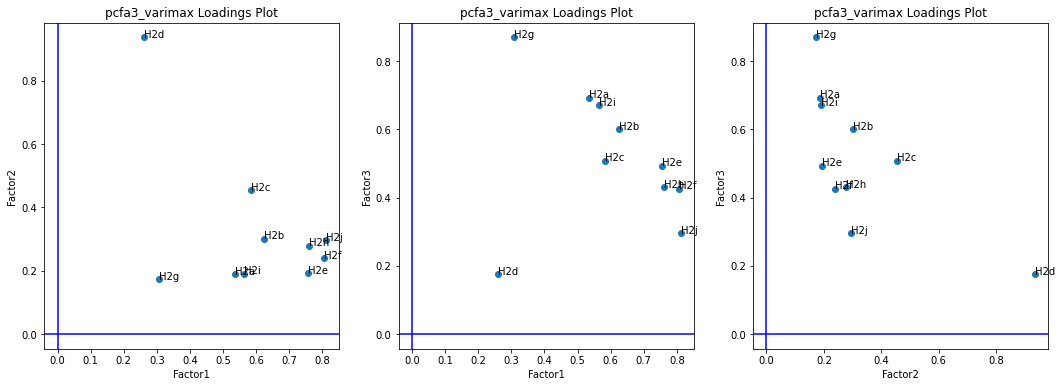

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(18, 6)
)
loadings_plot(pc_result[5][["Factor1", "Factor2"]], f"{pc_label[5]} Loadings Plot", ax=ax1)
loadings_plot(pc_result[5][["Factor1", "Factor3"]], f"{pc_label[5]} Loadings Plot", ylabel="Factor3", ax=ax2)
loadings_plot(pc_result[5][["Factor2", "Factor3"]], f"{pc_label[5]} Loadings Plot", xlabel="Factor2", ylabel="Factor3", ax=ax3)
fig.savefig("../fig/fa_pcfa3_varimax_loadings.png")

### MLFA: 2 factors

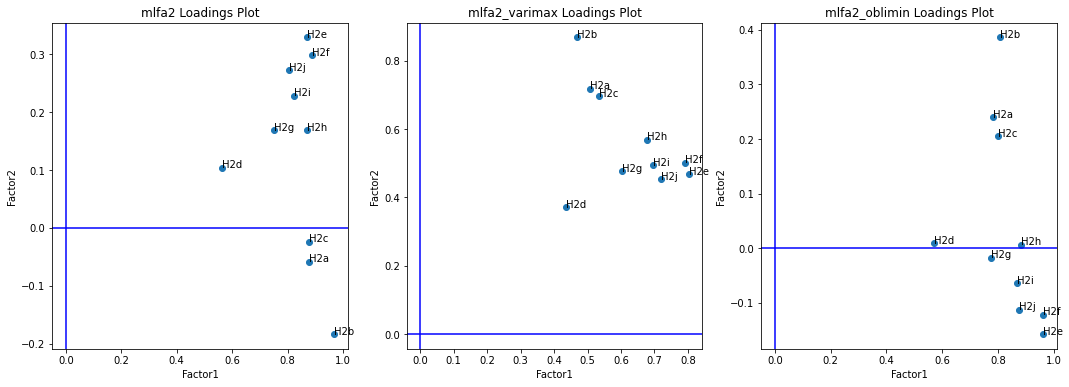

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(18, 6)
)
loadings_plot(ml_result[3][["Factor1", "Factor2"]], f"{ml_label[3]} Loadings Plot", ax=ax1)
loadings_plot(ml_result[4][["Factor1", "Factor2"]], f"{ml_label[4]} Loadings Plot", ax=ax2)
loadings_plot(ml_result[5][["Factor1", "Factor2"]], f"{ml_label[5]} Loadings Plot", ax=ax3)
fig.savefig("../fig/fa_mlfa2_loadings.png")

### MLFA: 3 factors

#### MLFA3

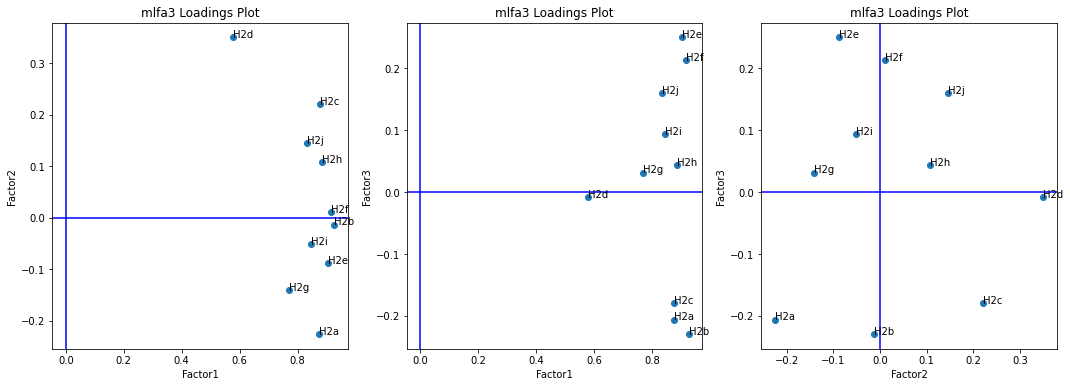

In [134]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(18, 6)
)
loadings_plot(ml_result[6][["Factor1", "Factor2"]], f"{ml_label[6]} Loadings Plot", ax=ax1)
loadings_plot(ml_result[6][["Factor1", "Factor3"]], f"{ml_label[6]} Loadings Plot", ylabel="Factor3", ax=ax2)
loadings_plot(ml_result[6][["Factor2", "Factor3"]], f"{ml_label[6]} Loadings Plot", xlabel="Factor2", ylabel="Factor3", ax=ax3)
fig.savefig("../fig/fa_mlfa3_loadings.png")

#### MLFA3_varimax

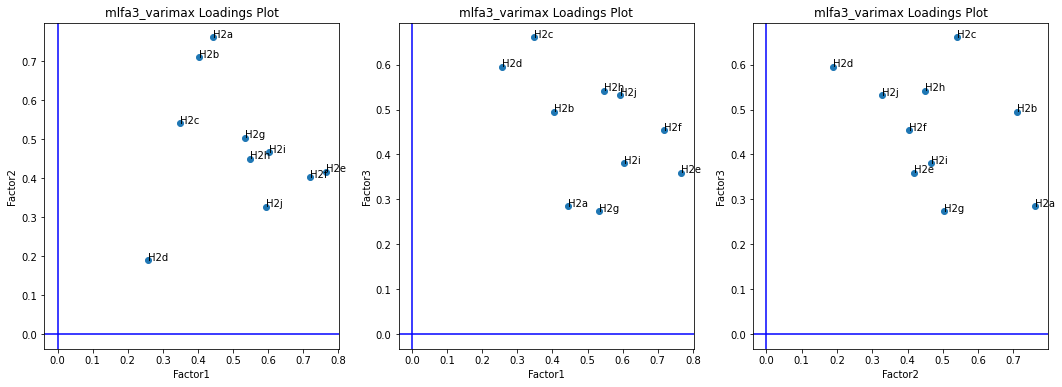

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(18, 6)
)
loadings_plot(ml_result[7][["Factor1", "Factor2"]], f"{ml_label[7]} Loadings Plot", ax=ax1)
loadings_plot(ml_result[7][["Factor1", "Factor3"]], f"{ml_label[7]} Loadings Plot", ylabel="Factor3", ax=ax2)
loadings_plot(ml_result[7][["Factor2", "Factor3"]], f"{ml_label[7]} Loadings Plot", xlabel="Factor2", ylabel="Factor3", ax=ax3)
fig.savefig("../fig/fa_mlfa3_varimax_loadings.png")

#### MLFA3_oblimin

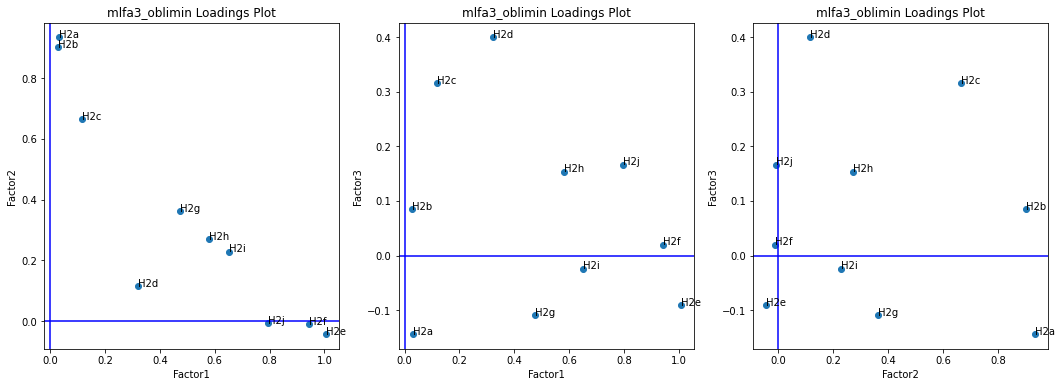

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(18, 6)
)
loadings_plot(ml_result[8][["Factor1", "Factor2"]], f"{ml_label[8]} Loadings Plot", ax=ax1)
loadings_plot(ml_result[8][["Factor1", "Factor3"]], f"{ml_label[8]} Loadings Plot", ylabel="Factor3", ax=ax2)
loadings_plot(ml_result[8][["Factor2", "Factor3"]], f"{ml_label[8]} Loadings Plot", xlabel="Factor2", ylabel="Factor3", ax=ax3)
fig.savefig("../fig/fa_mlfa3_oblimin_loadings.png")